In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy import special, optimize

In [2]:
def get_csv(filename, headDrop, tailDrop):
    df = pd.read_csv(filename, header=None, sep='\n');

    # Remove file header (1st 11 rows)
    r = 11;
    for i in range(r):
        df = df.drop([i]);

    # Split columns by commas
    df = df[0].str.split(",", expand=True);

    new_header = df.iloc[0]; #grab the first row for the header
    df = df[1:]; #take the data less the header row
    df.columns = new_header; #set the header row as the df header

    units = df.iloc[0]; # Get units
    df = df.drop([r+1]); # Remove units row from dataframe
    
    df.drop(df.head(headDrop).index, inplace=True) # drop first headDrop rows
    df.drop(df.tail(tailDrop).index, inplace=True) # drop last tailDrop rows
    '''
    if headDrop > 0:
        for i in range(headDrop):
            df = df.drop([r+2+i]);
            
    if tailDrop > 0:
        for i in range(tailDrop):
            df = df.drop([len(df)]);
    '''

    #      [0]    [1]
    return units, df;

In [3]:
def compareData_(plotname, filemanes, headDrop, tailDrop, plotlabels):
    
    # Get units
    units_df = get_csv(filemanes[0], headDrop[0], tailDrop[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Chose what to plot
    x_index = 1
    y_index = 2

    # Plot
    for i in range(len(filemanes)):
        _0_ps_thf_df = get_csv(filemanes[i], headDrop[i], tailDrop[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].to_numpy().astype(np.float)
        plt.scatter(x, y, s=(i*4)+2, label=plotlabels[i]);
        plt.plot(x, y, linewidth=0.125);
        minY = min(y)
        maxY = max(y)
    
    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 18});
    display(plt);

### The Bird-Carreau-Yasuda Model [1]
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [4]:
def GNF_(gamma, eta_inft, eta_zero, kappa, n, a): # The Bird-Carreau-Yasuda Model Bird
    nume = eta_zero - eta_inft;
    
    base = 1 + (kappa*gamma)**a
    expo = (1 - n)/a
    deno = base**expo;
    
    return (nume/deno) + eta_inft

In [5]:
def fit_GNF_(filename, headDrop, tailDrop, plotname, a):
    # Get units
    #units_df = get_csv("./csv/oskt 0_ps_thf.csv")[0]
    units_df = get_csv(filename, headDrop, tailDrop)[0]

    # Get CSV data
    #nSeal_df = get_csv("./csv/oskt 0_ps_thf.csv")[1]
    nSeal_df = get_csv(filename, headDrop, tailDrop)[1]

    # reasonable initial guesses for EOS parameters
    eta_inft = 0
    eta_zero = 1
    kappa    = 1
    n        = 0
    #a        = 9

    # # PRINT table with fittig parameters
    # tmplt_str_l = "  ".join(["{:<15}"] + ["{:<15}"]*5);
    # tmplt_str_s = "  ".join(["{:<15}"] + ["{:<15.7}"]*5);
    # print('')
    # print('Fitting:')
    # print(tmplt_str_l.format(*['parameters:', 'eta_inft', 'eta_zero', 'kappa', 'n', 'a']));
    # print("-" * 96);

    # Chose what to plot
    x_index = 1; # gamma = Shear rate
    y_index = 2; # eta   = Viscosity

    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);
    
    #print(gamma, eta)
    
    #eta_prev = GNF_(gamma, eta_inft, eta_zero, kappa, n, a);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    p0 = eta_inft, eta_zero, kappa, n, a;
    results = optimize.curve_fit(GNF_, gamma, eta, p0)

    eta_inft = results[0][0];
    eta_zero = results[0][1];
    kappa    = results[0][2];
    n        = results[0][3];
    a        = results[0][4];
    
    gamma_fit = gamma #np.linspace(minX, maxX, 1000); #gamma
    eta_fit = GNF_(gamma_fit, eta_inft, eta_zero, kappa, n, a)

    # # PRINT table with fittig parameters
    # print(tmplt_str_s.format('Fit curve', *results[0], 0));

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Plot
    plt.scatter(gamma, eta, s=25, color='red', label='Collected data');
    plt.plot(gamma, eta, linewidth=0.125, color='red');
    plt.plot(gamma_fit, eta_fit, '-', linewidth=3, label='Fitted curve');

    # Print fitting parameters as plot legends
    x = gamma[0]
    y = eta[0]
    plt.scatter(x, y, s=0, label=' ')
    plt.scatter(x, y, s=0, label=r'$\eta_{\infty} = $' + str(round(eta_inft, 6)) + r' $Pa \cdot s$')
    plt.scatter(x, y, s=0, label=r'$\eta_0 = $' + str(round(eta_zero, 6)) + r' $Pa \cdot s$')
    #plt.scatter(x, y, s=0, label=r'$\kappa = $' + str(round(kappa, 6)))
    #plt.scatter(x, y, s=0, label=r'$n = $' + str(round(n, 6)))
    #plt.scatter(x, y, s=0, label=r'$a = $' + str(round(a, 6)))

    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(nSeal_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(nSeal_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 18});
    display(plt);

---
---
# PEO in SU8

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

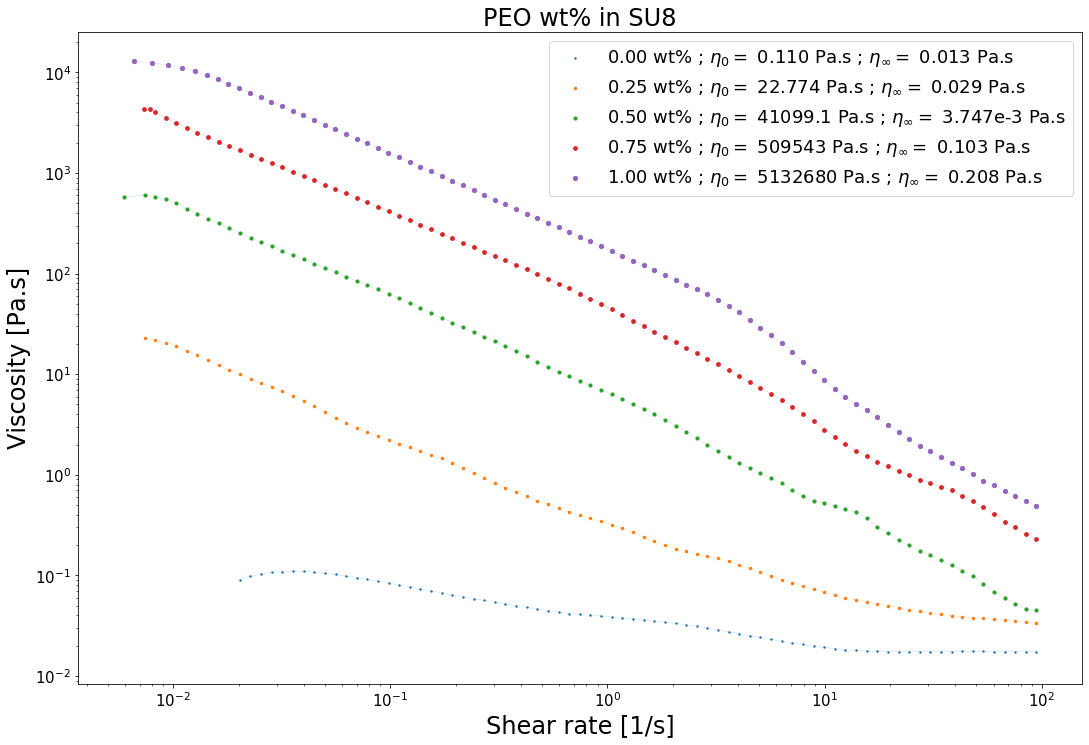

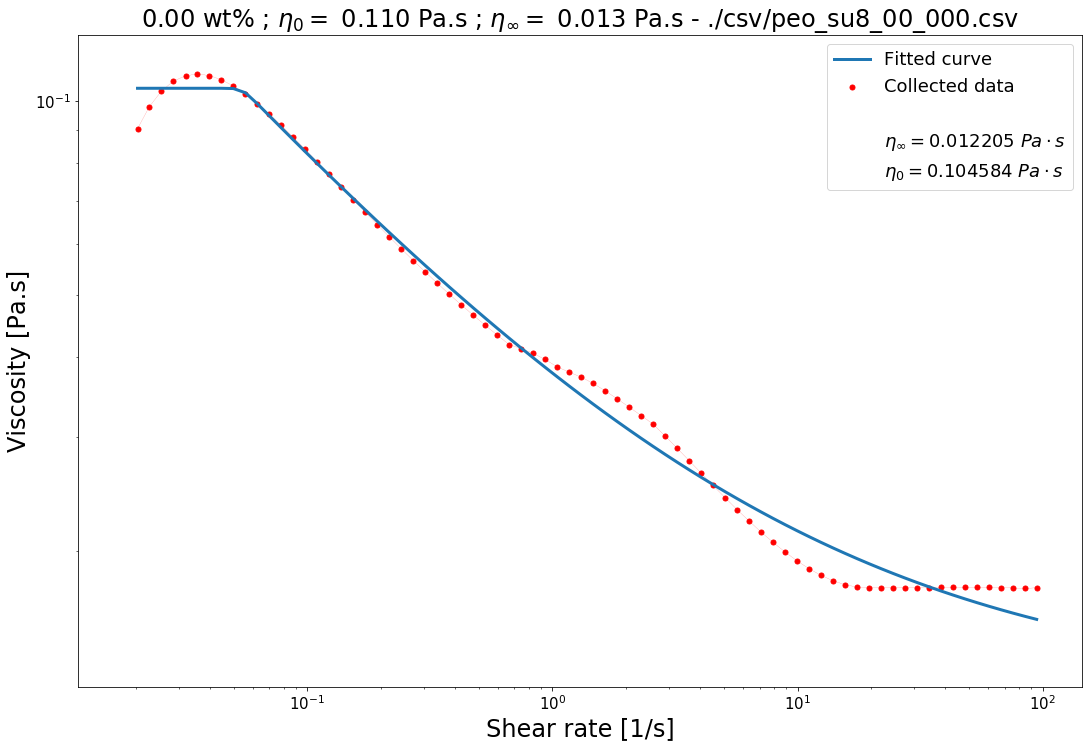

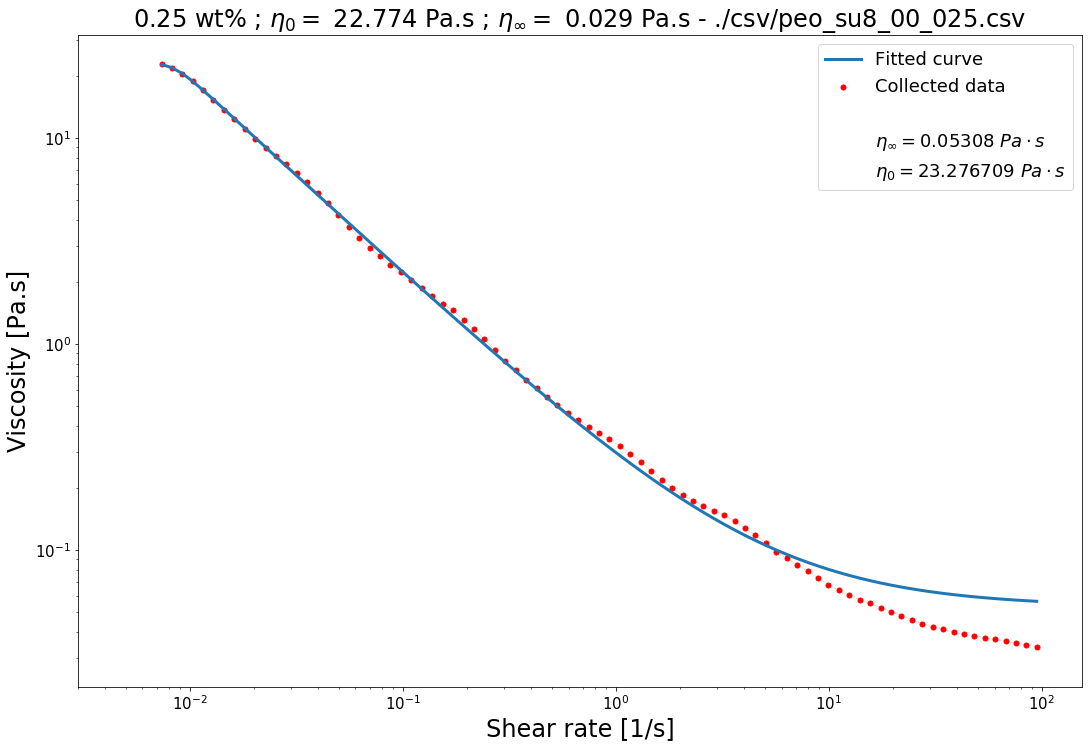

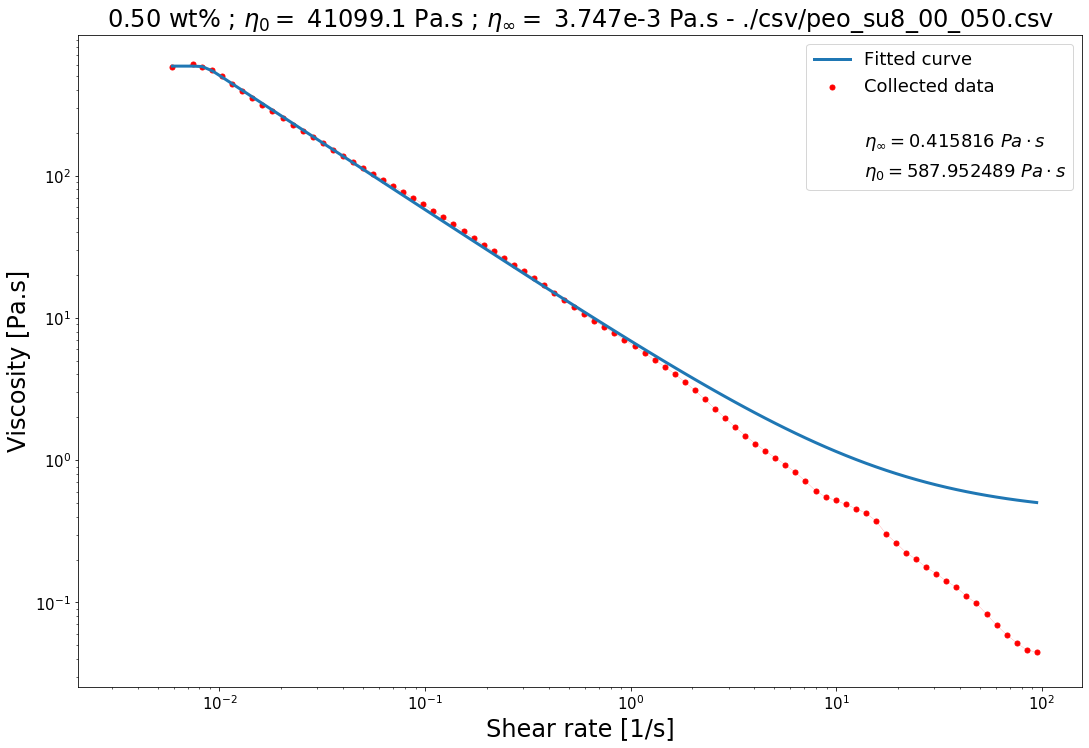

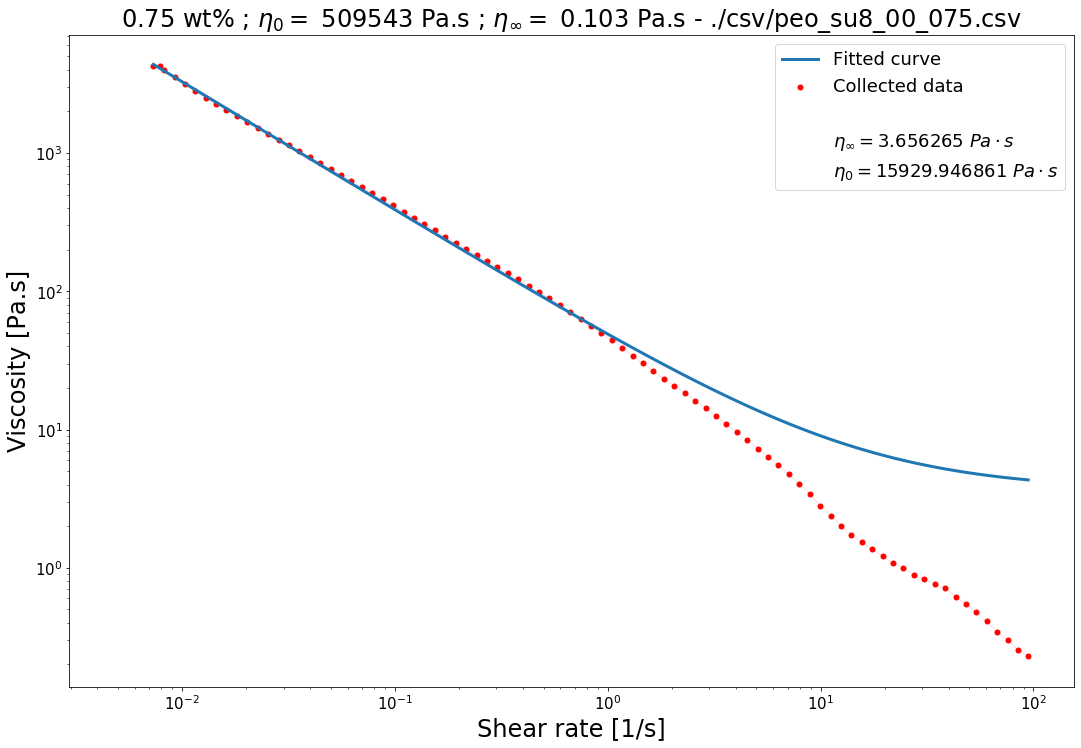

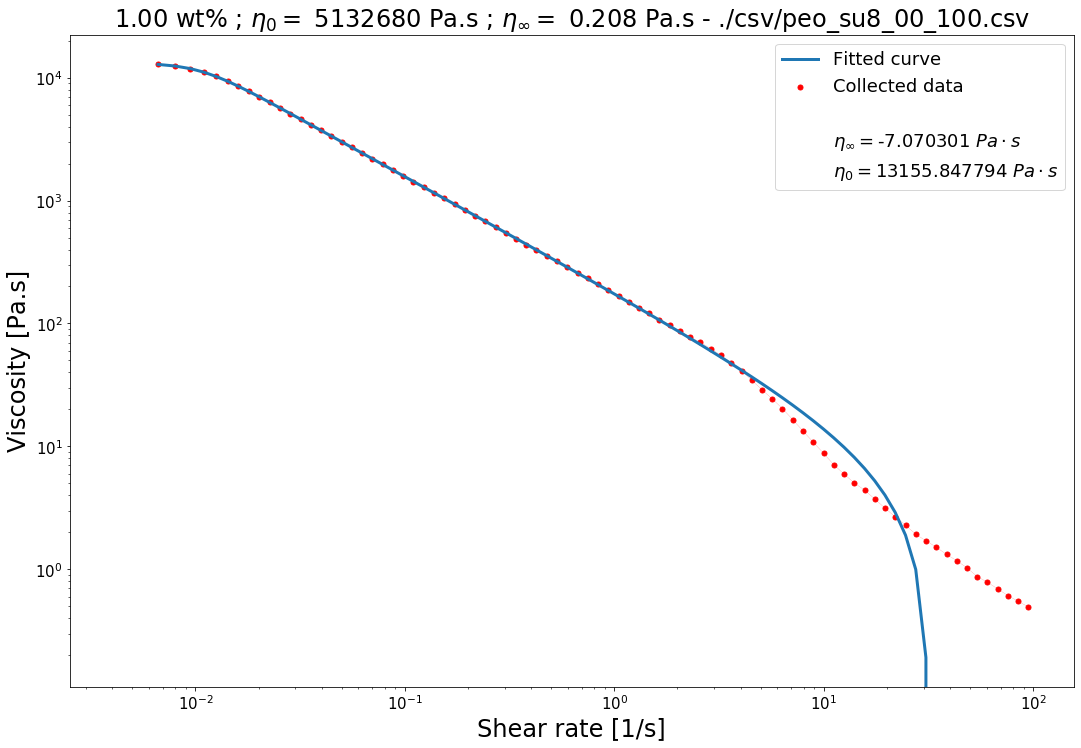

In [62]:
plotName  = "PEO wt% in SU8";
fileNames = [
    "./csv/peo_su8_00_000.csv",
    "./csv/peo_su8_00_025.csv",
    "./csv/peo_su8_00_050.csv",
    "./csv/peo_su8_00_075.csv",
    "./csv/peo_su8_00_100.csv"
];
fileDescription = [
    "0.00 wt% ; " + r'$\eta_0 = $' + " 0.110 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.013 Pa.s",
    "0.25 wt% ; " + r'$\eta_0 = $' + " 22.774 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.029 Pa.s",
    "0.50 wt% ; " + r'$\eta_0 = $' + " 41099.1 Pa.s ; " + r'$\eta_{\infty} = $' + " 3.747e-3 Pa.s",
    "0.75 wt% ; " + r'$\eta_0 = $' + " 509543 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.103 Pa.s",
    "1.00 wt% ; " + r'$\eta_0 = $' + " 5132680 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.208 Pa.s"
];
headDrops = [10, 0, 0, 0, 0];
tailDrops = [ 0, 0, 0, 0, 0];
a         = [ 1, 1, 1, 1, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

# Fit the GNF model to each file
for i in range(len(fileNames)):
    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PS in THF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

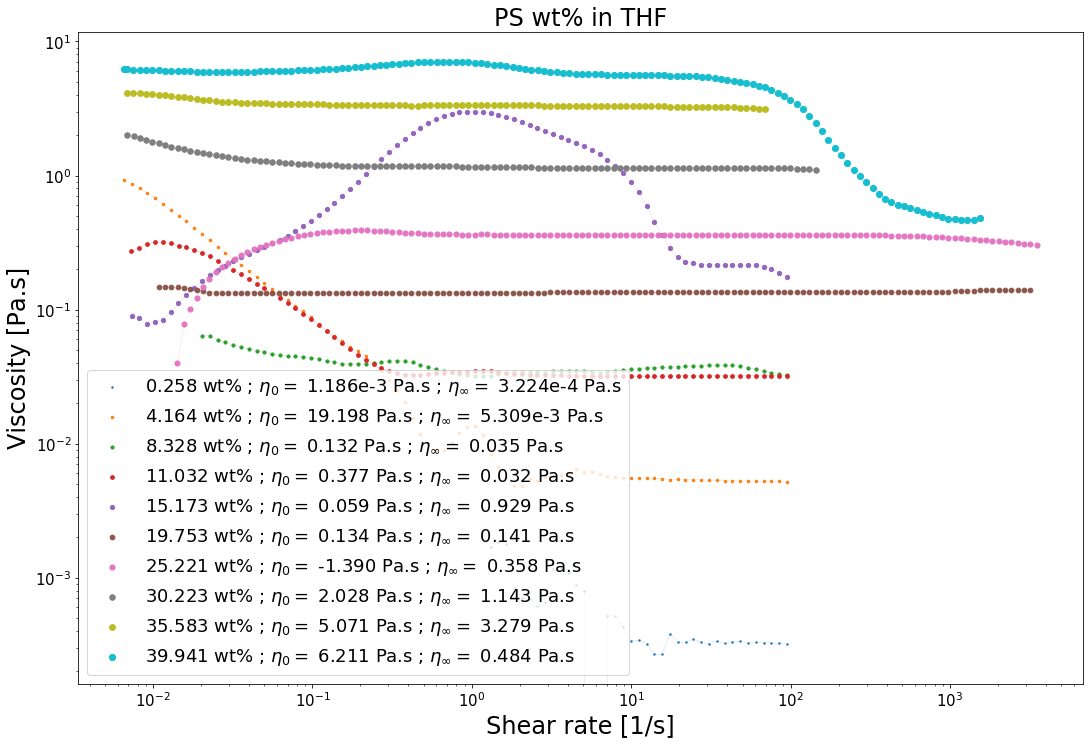

In [60]:
plotName  = "PS wt% in THF";
fileNames = [
    "./csv/ps_thf_00_0.csv",
    "./csv/ps_thf_00_1.csv",
    "./csv/ps_thf_00_2.csv",
    "./csv/ps_thf_00_3.csv",
    "./csv/ps_thf_00_4.csv",
    "./csv/ps_thf_01_0.csv",
    "./csv/ps_thf_01_1.csv",
    "./csv/ps_thf_01_2.csv",
    "./csv/ps_thf_01_3.csv",
    "./csv/ps_thf_01_4.csv"
];
fileDescription = [
    "0.258 wt% ; " + r'$\eta_0 = $' + " 1.186e-3 Pa.s ; " + r'$\eta_{\infty} = $' + " 3.224e-4 Pa.s",
    "4.164 wt% ; " + r'$\eta_0 = $' + " 19.198 Pa.s ; " + r'$\eta_{\infty} = $' + " 5.309e-3 Pa.s",
    "8.328 wt% ; " + r'$\eta_0 = $' + " 0.132 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.035 Pa.s",
    "11.032 wt% ; " + r'$\eta_0 = $' + " 0.377 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.032 Pa.s",
    "15.173 wt% ; " + r'$\eta_0 = $' + " 0.059 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.929 Pa.s",
    "19.753 wt% ; " + r'$\eta_0 = $' + " 0.134 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.141 Pa.s",
    "25.221 wt% ; " + r'$\eta_0 = $' + " -1.390 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.358 Pa.s",
    "30.223 wt% ; " + r'$\eta_0 = $' + " 2.028 Pa.s ; " + r'$\eta_{\infty} = $' + " 1.143 Pa.s",
    "35.583 wt% ; " + r'$\eta_0 = $' + " 5.071 Pa.s ; " + r'$\eta_{\infty} = $' + " 3.279 Pa.s",
    "39.941 wt% ; " + r'$\eta_0 = $' + " 6.211 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.484 Pa.s"
];
headDrops = [47, 0,   10, 1, 1,  6,  9,  1,    1,  0];
tailDrops = [ 0, 0,    0, 0, 0, 18, 17, 52,   60, 26];
a         = [10, 2, 1000, 1, 1, 80, 100, 1, 1000, 47];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PSB in NMP

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

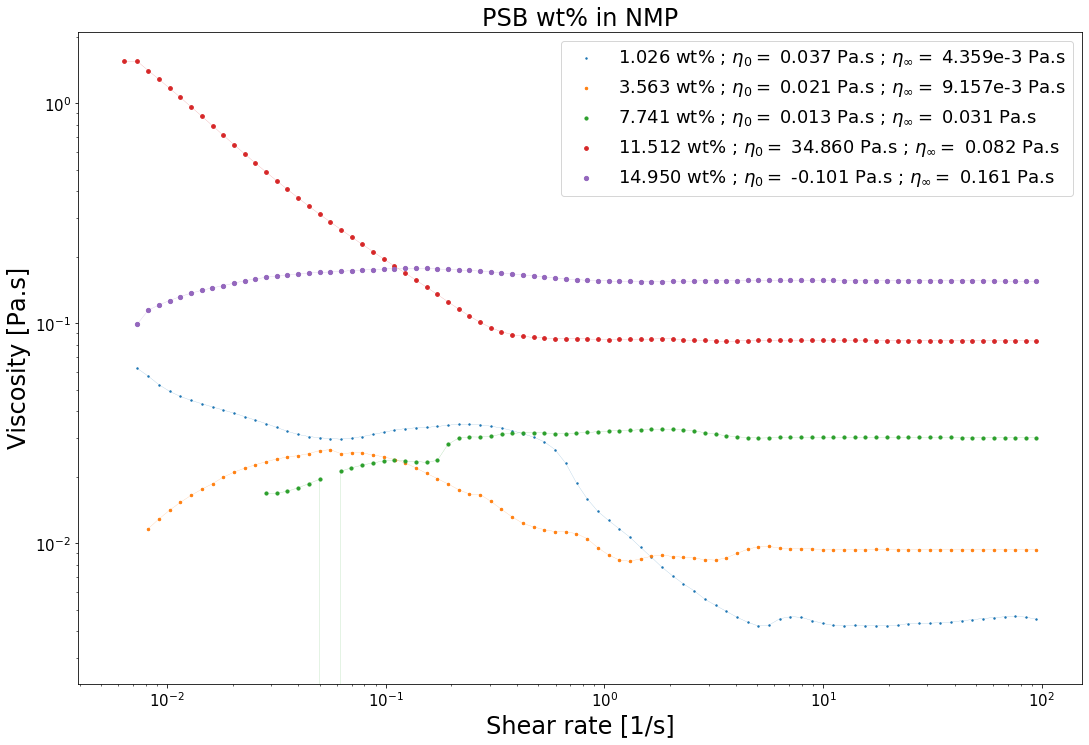

In [61]:
plotName  = "PSB wt% in NMP";
fileNames = [
    "./csv/psb_nmp_00_10.csv",
    "./csv/psb_nmp_00_11.csv",
    "./csv/psb_nmp_00_12.csv",
    "./csv/psb_nmp_00_13.csv",
    "./csv/psb_nmp_00_14.csv"
];
fileDescription = [
    "1.026 wt% ; " + r'$\eta_0 = $' + " 0.037 Pa.s ; " + r'$\eta_{\infty} = $' + " 4.359e-3 Pa.s",
    "3.563 wt% ; " + r'$\eta_0 = $' + " 0.021 Pa.s ; " + r'$\eta_{\infty} = $' + " 9.157e-3 Pa.s",
    "7.741 wt% ; " + r'$\eta_0 = $' + " 0.013 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.031 Pa.s",
    "11.512 wt% ; " + r'$\eta_0 = $' + " 34.860 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.082 Pa.s",
    "14.950 wt% ; " + r'$\eta_0 = $' + " -0.101 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.161 Pa.s"
];
headDrops = [   1, 2,  13,   0, 1];
tailDrops = [   0, 0,   0,   0, 0];
a         = [1000, 1, 100, 500, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PSB in THF and DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

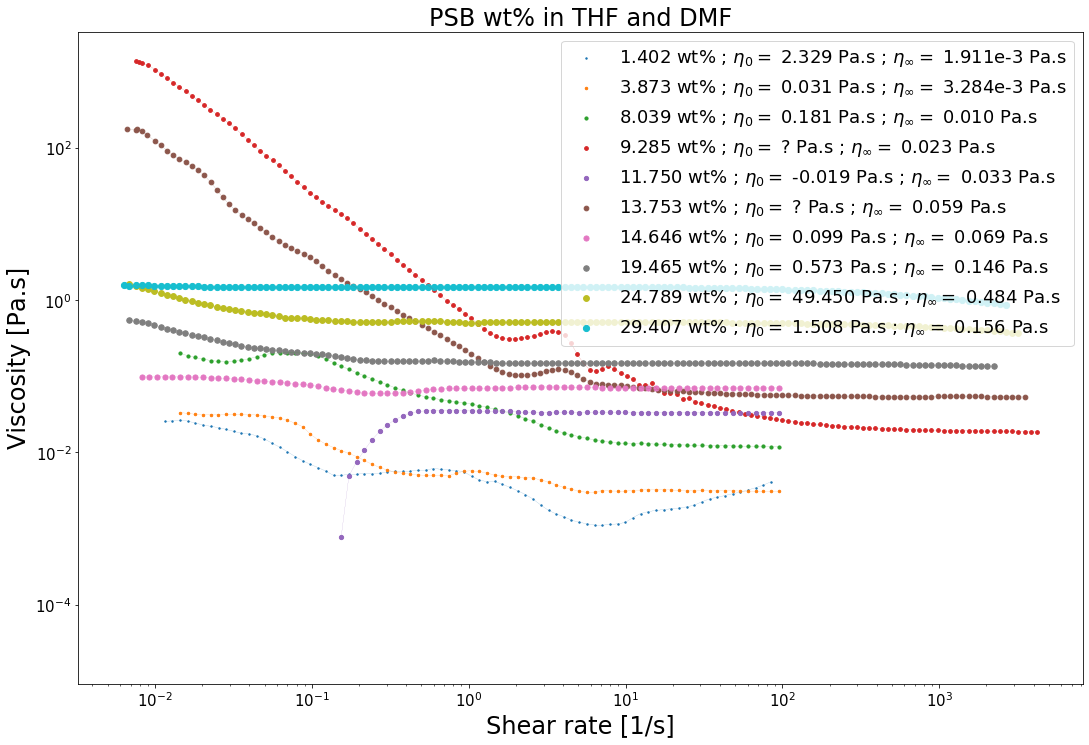

In [63]:
plotName  = "PSB wt% in THF and DMF";
fileNames = [
    "./csv/PSB_THFDMF_00_5.csv",
    "./csv/PSB_THFDMF_00_6.csv",
    "./csv/PSB_THFDMF_00_7.csv",
    "./csv/PSB_THFDMF_01_5.csv",
    "./csv/PSB_THFDMF_00_8.csv",
    "./csv/PSB_THFDMF_01_6.csv",
    "./csv/PSB_THFDMF_00_9.csv",
    "./csv/PSB_THFDMF_01_7.csv",
    "./csv/PSB_THFDMF_01_8.csv",
    "./csv/PSB_THFDMF_01_9.csv"
];
fileDescription = [
    "1.402 wt% ; " + r'$\eta_0 = $' + " 2.329 Pa.s ; " + r'$\eta_{\infty} = $' + " 1.911e-3 Pa.s",
    "3.873 wt% ; " + r'$\eta_0 = $' + " 0.031 Pa.s ; " + r'$\eta_{\infty} = $' + " 3.284e-3 Pa.s",
    "8.039 wt% ; " + r'$\eta_0 = $' + " 0.181 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.010 Pa.s",
    "9.285 wt% ; " + r'$\eta_0 = $' + " ? Pa.s ; " + r'$\eta_{\infty} = $' + " 0.023 Pa.s",
    "11.750 wt% ; " + r'$\eta_0 = $' + " -0.019 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.033 Pa.s",
    "13.753 wt% ; " + r'$\eta_0 = $' + " ? Pa.s ; " + r'$\eta_{\infty} = $' + " 0.059 Pa.s",
    "14.646 wt% ; " + r'$\eta_0 = $' + " 0.099 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.069 Pa.s",
    "19.465 wt% ; " + r'$\eta_0 = $' + " 0.573 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.146 Pa.s",
    "24.789 wt% ; " + r'$\eta_0 = $' + " 49.450 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.484 Pa.s",
    "29.407 wt% ; " + r'$\eta_0 = $' + " 1.508 Pa.s ; " + r'$\eta_{\infty} = $' + " 0.156 Pa.s"
];
headDrops = [ 5, 7,   7,  1,  28,   1, 2,   1,  1,  0];
tailDrops = [ 1, 0,   0, 15,   0,  17, 0,  22, 18, 20];
a         = [10, 1, 500,  1, 200, 900, 1000, 700,  1,  1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PSMS in DMF

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

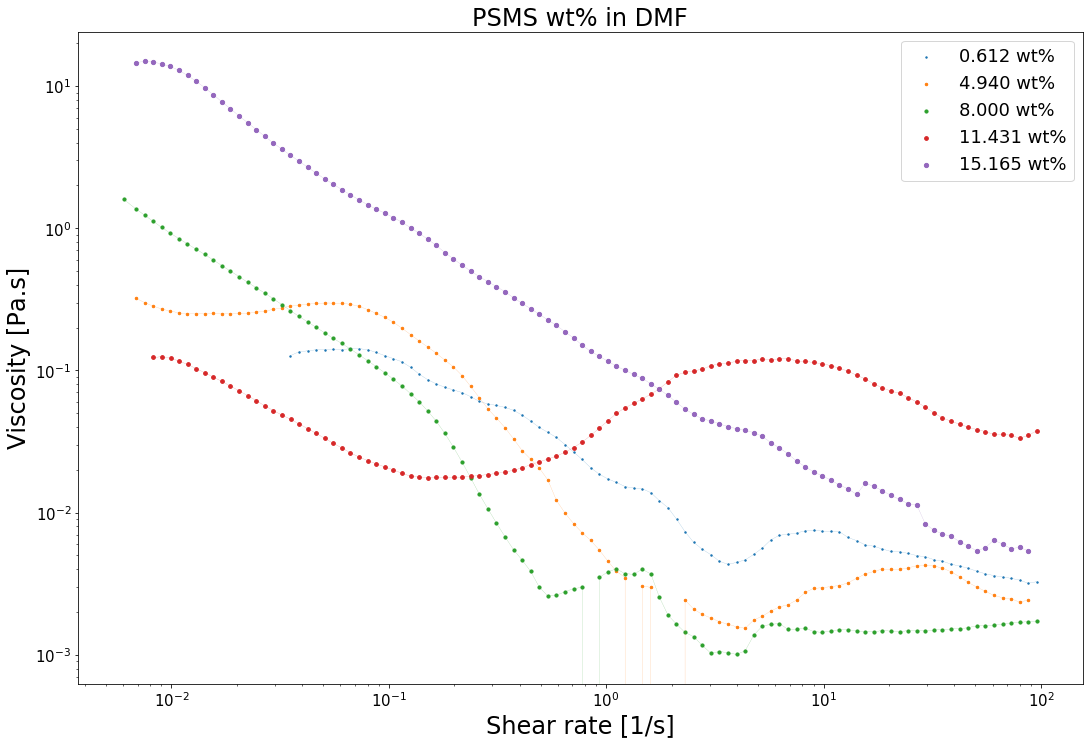

In [42]:
plotName  = "PSMS wt% in DMF";
fileNames = [
    "./csv/psms_dmf_00_6.csv",
    "./csv/psms_dmf_00_7.csv",
    "./csv/psms_dmf_00_8.csv",
    "./csv/psms_dmf_00_9.csv",
    "./csv/psms_dmf_00_10.csv"
];
fileDescription = [
    "0.612 wt% ; " + r'$\eta_0 = $' + " 0.161 Pa.s ; " + r'$\eta_{\infty} = $' + " 4.652e-3 Pa.s",
    "4.940 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "8.000 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "11.431 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "15.165 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s"
];
headDrops = [18, 1, 0, 3, 0];
tailDrops = [ 0, 1, 0, 0, 1];
a         = [ 1, 1, 1, 100, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PVK in CHL

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

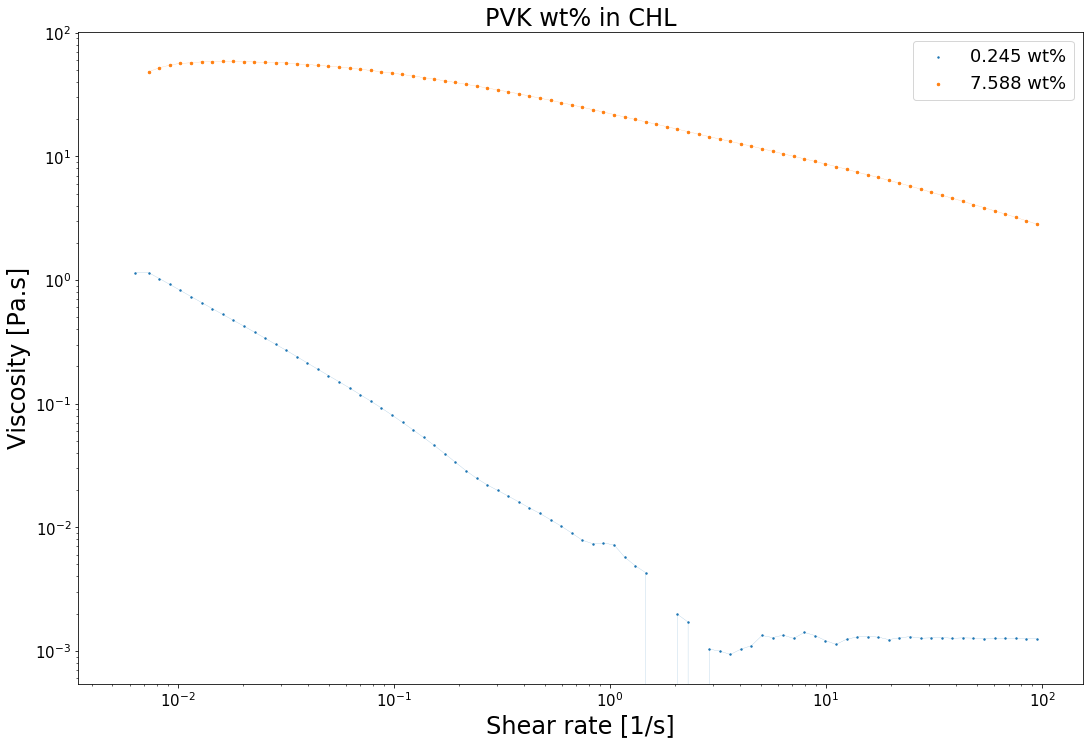

In [47]:
plotName  = "PVK wt% in CHL";
fileNames = [
    "./csv/pvk_chl_00_0.csv",
    "./csv/pvk_chl_00_1.csv"
];
fileDescription = [
    "0.245 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "7.588 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s"
];
headDrops = [ 1, 1];
tailDrops = [ 0, 0];
a         = [10, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# PVK in DCM

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

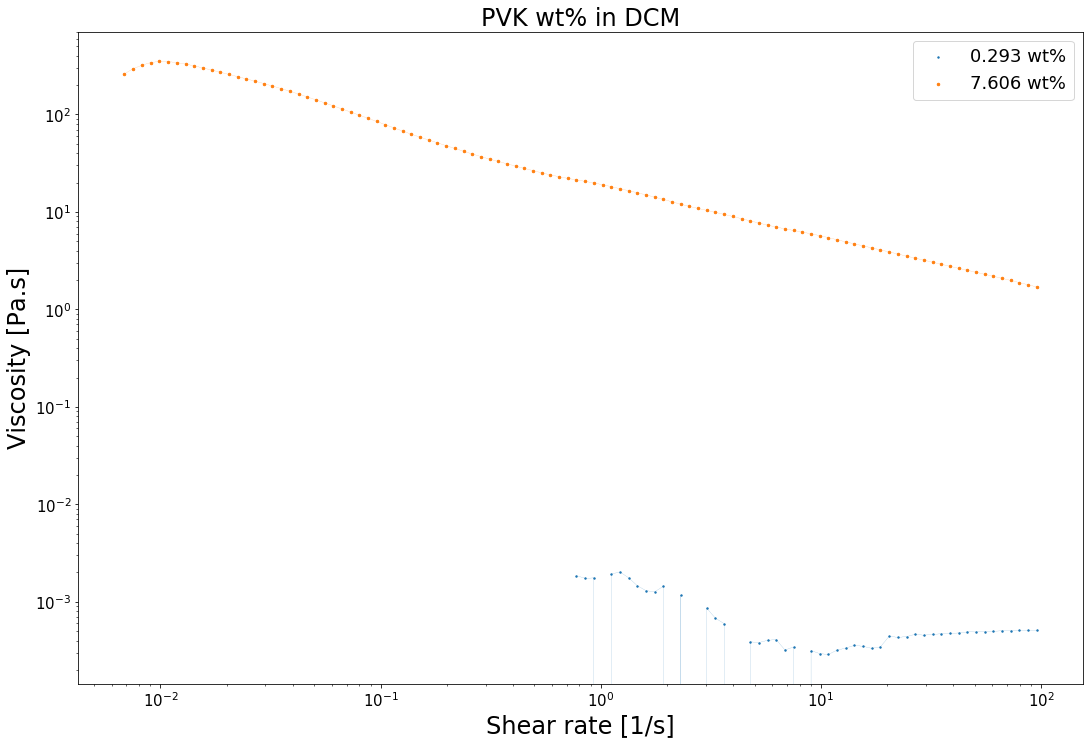

In [53]:
plotName  = "PVK wt% in DCM";
fileNames = [
    "./csv/pvk_dcm_00_3.csv",
    "./csv/pvk_dcm_00_4.csv"
];
fileDescription = [
    "0.293 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "7.606 wt% ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s"
];
headDrops = [  53, 1];
tailDrops = [   0, 0];
a         = [1000, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])

---
# Standard Conforming to ASTM Oil Standard

11
Stress                          Pa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                   Pa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 12, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

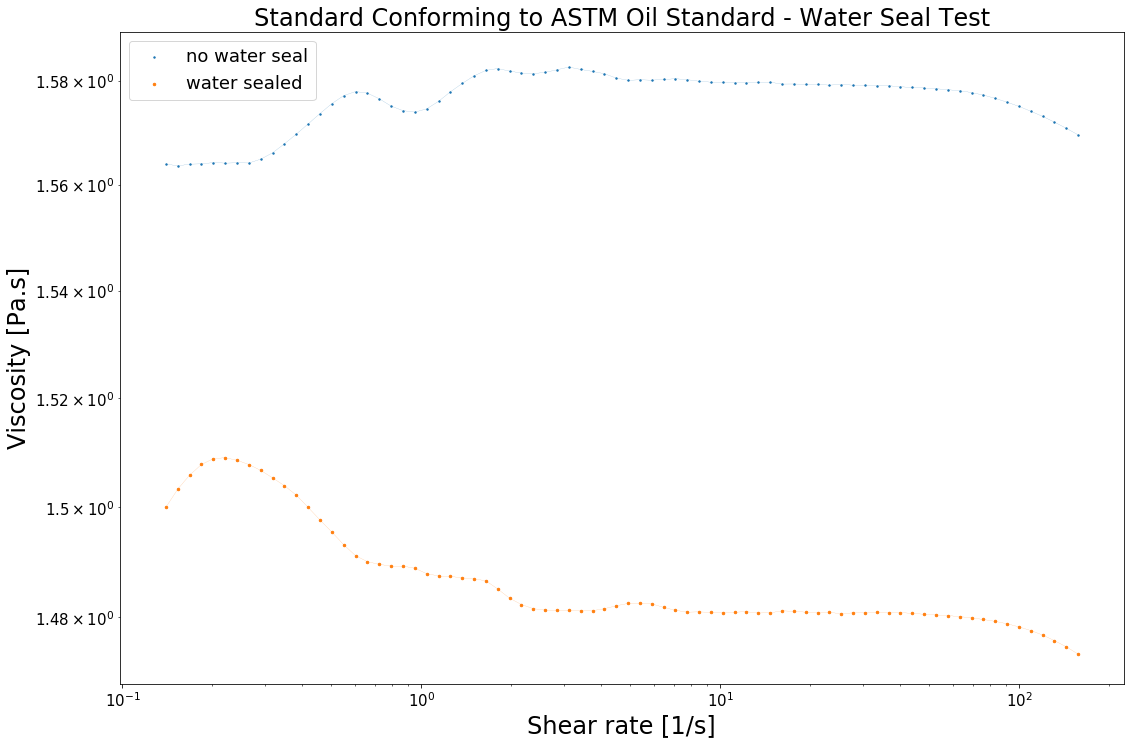

In [55]:
plotName  = "Standard Conforming to ASTM Oil Standard - Water Seal Test";
fileNames = [
    "./csv/std_noseal.csv",
    "./csv/std_sealed.csv"
];
fileDescription = [
    "no water seal ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s",
    "water sealed ; " + r'$\eta_0 = $' + "  Pa.s ; " + r'$\eta_{\infty} = $' + "  Pa.s"
];
headDrops = [34, 34];
tailDrops = [51, 51];
a = [1, 1];

# Plot all files in one plot
compareData_(plotName, fileNames, headDrops, tailDrops, fileDescription)

## Fit the GNF model to each file
#for i in range(len(fileNames)):
#    fit_GNF_(fileNames[i], headDrops[i], tailDrops[i], fileDescription[i] + " - " + fileNames[i],  a[i])